In [127]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
from langchain_core.runnables.config import RunnableConfig
from azure.identity import DefaultAzureCredential
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from chromadb import PersistentClient
from chromadb.utils.embedding_functions import EmbeddingFunction
from transformers import AutoTokenizer, AutoModel


load_dotenv()

DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///example.db")
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

CHROMA_DB_DIR = "./chroma_db"
COLLECTION_NAME = "schema_embeddings"
EMBEDDING_MODEL_NAME = "BAAI/bge-m3"

Base = declarative_base()


# Definition of the Users table
class User(Base):
    __tablename__ = "users"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, index=True)
    age = Column(Integer)
    email = Column(String, unique=True, index=True)

    orders = relationship("Order", back_populates="user")

# Definition of the Food table
class Food(Base):
    __tablename__ = "food"

    id = Column(Integer, primary_key=True, index=True)
    name = Column(String, unique=True, index=True)
    price = Column(Float)

    orders = relationship("Order", back_populates="food")

# Definition of the Orders table
class Order(Base):
    __tablename__ = "orders"

    id = Column(Integer, primary_key=True, index=True)
    food_id = Column(Integer, ForeignKey("food.id"))
    user_id = Column(Integer, ForeignKey("users.id"))

    user = relationship("User", back_populates="orders")
    food = relationship("Food", back_populates="orders")

## Functions for Agent

In [155]:
import os
from typing import List, Optional
from chromadb import PersistentClient
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, END
import json
from langchain_core.prompts.chat import SystemMessage, HumanMessage
# Load environment variables
load_dotenv()

# Define the path to the ChromaDB directory
CHROMA_DB_DIR = os.getenv("CHROMA_DB_DIR", "chromadb")

class AgentState(TypedDict):
    question: str
    sql_query: Optional[str]
    query_result: Optional[str]
    query_rows: List[dict]
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool
    context: List[str]
    chart_type: Optional[str]
    chart_title: Optional[str]
    schema_info: str
    database_description: str
    graph: StateGraph
    

MAX_RETRIES = 3



def get_database_schema(state: AgentState, config: dict):
    """
    Extracts relevant schema information and generates a database description.

    Args:
        state (AgentState): Current agent state containing the question.
        config (dict): Configuration dictionary.

    Returns:
        AgentState: Updated state with extracted schema information and a database description.
    """
    question = state["question"]

    # Retrieve relevant schema context using hybrid search
    context = hybrid_search(
        question,
        schema,  # Extracted database schema
        chroma_collection,
        embedding_model,
        graph,
        max_results=15  # Retrieve top 15 relevant elements
    )

    if not context:
        state["schema_info"] = ""
        state["database_description"] = ""
        print("[DEBUG] No relevant schema found.")
        return state

    # Extract schema information for relevant tables
    schema_info = ["### Relevant Schema Information"]
    relevant_tables = set()

    for node in context:
        try:
            node_type = graph.nodes[node]["type"]
            if node_type == "table":
                relevant_tables.add(node)
            elif node_type == "column":
                relevant_tables.add(graph.nodes[node]["table"])
        except KeyError:
            continue  # Skip invalid nodes

    # Generate structured schema details
    table_summaries = []
    for table in relevant_tables:
        table_metadata = graph.nodes[table]
        primary_keys = table_metadata.get("primary_keys", [])
        examples = table_metadata.get("examples", {})

        schema_info.append(f"\nTable: {table}")
        if primary_keys:
            schema_info.append(f"  - Primary Keys: {', '.join(primary_keys)}")
        if examples:
            schema_info.append(f"  - Examples: {examples}")

        # Summarize table for LLM description
        summary = f"Table '{table}' contains {len(graph[table])} columns."
        if primary_keys:
            summary += f" It has primary key(s): {', '.join(primary_keys)}."
        if examples:
            summary += f" Example values include: {', '.join(map(str, list(examples.values())[:3]))}."
        table_summaries.append(summary)

        # Add column details
        for neighbor in graph.neighbors(table):
            try:
                if graph.nodes[neighbor]["type"] == "column":
                    column_metadata = graph.nodes[neighbor]
                    column_name = neighbor.split(".")[1]
                    column_type = column_metadata["data_type"]
                    primary_key = column_metadata.get("primary_key", False)
                    column_examples = column_metadata.get("examples", [])

                    # Highlight relevant columns
                    if neighbor in context:
                        schema_info.append(
                            f"  - {column_name} ({column_type}) [RELEVANT] - "
                            f"{'Primary Key' if primary_key else ''} "
                            f"{f'Examples: {column_examples}' if column_examples else ''}"
                        )
                    else:
                        schema_info.append(
                            f"  - {column_name} ({column_type}) - "
                            f"{'Primary Key' if primary_key else ''} "
                            f"{f'Examples: {column_examples}' if column_examples else ''}"
                        )
            except KeyError:
                continue

    # Generate a human-readable database description using LLM
    system_prompt = f"""
    You are an expert in database systems. Given the extracted schema information below,
    provide a concise and informative 5-6 sentence description of the database.
    
    **Extracted Schema Information:**
    {'. '.join(table_summaries)}

    The description should be clear, mentioning the key tables, their purpose, and how they relate to each other.
    """
    
    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm([SystemMessage(content=system_prompt)])
    database_description = response.content.strip()

    # Store schema info and database description in state
    state["schema_info"] = "\n".join(schema_info)
    state["database_description"] = database_description

    # print(f"[DEBUG] Retrieved schema info successfully: {state['schema_info']}")
    if state['database_description'] == "":
        print("[DEBUG] No database description generated.")
        
    print(f"[DEBUG] Generated database description: {state['database_description']}")

    return state



class GetCurrentUser(BaseModel):
    current_user: str = Field(
        description="The name of the current user based on the provided user ID."
    )

def get_current_user(state: AgentState, config: RunnableConfig):
    print("Retrieving the current user based on user ID.")
    user_id = config["configurable"].get("current_user_id", None)
    if not user_id:
        state["current_user"] = "User not found"
        print("No user ID provided in the configuration.")
        return state

    session = SessionLocal()
    try:
        user = session.query(User).filter(User.id == int(user_id)).first()
        if user:
            state["current_user"] = user.name
            print(f"Current user set to: {state['current_user']}")
        else:
            state["current_user"] = "User not found"
            print("User not found in the database.")
    except Exception as e:
        state["current_user"] = "Error retrieving user"
        print(f"Error retrieving user: {str(e)}")
    finally:
        session.close()
    return state

class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_openai import ChatOpenAI



class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

# Convert Natural Language to SQL

def convert_nl_to_sql(state: AgentState):
    """Convert user question into an SQL query using extracted schema."""
    question = state["question"]
    schema_info = state.get("schema_info", "")
    data_description = state.get("database_description", "")

    if not schema_info:
        state["sql_query"] = ""
        print("[DEBUG] No schema info available.")
        return state

    # ✅ Ensure at least one categorical column is included in the query
    system_prompt = f"""
    Convert the question into an SQL query using this schema:

    **Question:** {question}
    **Database Schema:** {schema_info}
    **Database Description:** {data_description}

    **Requirements:**
    - Ensure the query contains at least ONE categorical column (e.g., `name`, `code`, `category`).
    - If necessary, include JOINs to retrieve meaningful relationships.
    - Output SQL only, no explanations.
    """

    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm.invoke([SystemMessage(content=system_prompt)])
    response_content = response.content.strip()

    # ✅ Remove unnecessary formatting
    if response_content.startswith("```sql") and response_content.endswith("```"):
        response_content = response_content[6:-3].strip()

    print("Cleaned LLM Response Content:", response_content)

    # ✅ Store SQL query in state
    state["sql_query"] = response_content
    return state


from sqlalchemy.exc import SQLAlchemyError, OperationalError

def execute_sql(state: AgentState) -> AgentState:
    """Execute SQL query with safety checks."""
    print("[DEBUG] Executing SQL query...")

    session = SessionLocal()
    state["sql_error"] = False

    try:
        sql_query = state.get("sql_query", "").strip()
        if not sql_query:
            raise ValueError("No SQL query provided.")
        if not sql_query.lower().startswith("select"):
            raise ValueError("Only SELECT queries are allowed.")

        result = session.execute(text(sql_query))
        columns = result.keys()
        rows = [dict(zip(columns, row)) for row in result.fetchall()]

        # ✅ Convert columns to correct types
        df = pd.DataFrame(rows)
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="ignore")

        state.update({
            "query_rows": rows,
            "query_result": f"Retrieved {len(rows)} records."
        })

    except Exception as e:
        state.update({
            "sql_error": True,
            "query_result": f"SQL Error: {str(e)}"
        })
    finally:
        session.close()

    print("[DEBUG] SQL Execution Completed - Retrieved", len(state["query_rows"]), "records.")
    return state





def regenerate_query(state: AgentState):
    """
    Reformulates the user's question to make it SQL-compatible based on database schema,
    previous SQL errors, and LLM-driven refinement.
    """
    if state["attempts"] >= MAX_RETRIES:
        state["query_result"] = "Max retries reached. Unable to process your request."
        state["sql_query"] = None  # Prevent further execution
        return state

    question = state["question"]
    database_description = state.get("database_description", "No database description available.")
    schema_info = state.get("schema_info", "No schema info available.")
    previous_sql_error = state.get("query_result", "")

    # Generate a structured prompt to reformulate the question
    system_prompt = f"""
    You are an expert in SQL and database systems. Your task is to refine the following natural language question
    to ensure it is clear, precise, and SQL-compatible.

    **Database Context:**
    {database_description}

    **Schema Details:**
    {schema_info}

    **User's Original Question:**
    "{question}"

    **Previous SQL Issue (if any):**
    {previous_sql_error}

    Please reformulate the question while keeping the original intent, ensuring it is properly structured
    for conversion into a valid SQL query. The output should be **only** the refined question, without any explanations.
    """

    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME"),
    )

    response = llm([SystemMessage(content=system_prompt)])
    refined_question = response.content.strip()

    # Store the refined question and update attempts
    state["question"] = refined_question
    state["attempts"] += 1

    print(f"[DEBUG] Refined Question (Attempt {state['attempts']}): {refined_question}")

    return state




def generate_human_readable_answer(state: AgentState) -> AgentState:
    """Generate a natural language response using LLM for query explanation and context."""
    print("[DEBUG] Generating human-readable answer with LLM")

    # Ensure `state` has all required keys
    state.setdefault("query_result", "")
    state.setdefault("query_rows", [])
    state.setdefault("sql_query", "")
    state.setdefault("database_description", "This database contains structured information relevant to your queries.")

    components = {
        "user": state.get("current_user", "User"),
        "error": state.get("sql_error", False),
        "result": state["query_result"],
        "rows": state["query_rows"],
        "chart_type": state.get("chart_type"),
        "chart_title": state.get("chart_title"),
        "sql_query": state["sql_query"],
        "database_description": state["database_description"]
    }

    # Define base message
    base_message = f"Hello {components['user']}, "

    # Handle errors properly
    if components["error"]:
        error_message = (
            f"there was an error executing your query.\n\n"
            f"🔴 **Error Details:** {components['result']}\n\n"
            "Possible reasons:\n"
            "- The table or column you requested might not exist.\n"
            "- There could be a syntax issue in the generated SQL query.\n"
            "- Database connectivity issues.\n\n"
            "📌 Try rephrasing your question or ensuring the data exists."
        )
        state["query_result"] = base_message + error_message
        return state  # ✅ Ensure function always returns `state`

    # Construct LLM prompt
    system_prompt = f"""
    You are an expert data analyst. Your task is to explain the results of a SQL query to a user in simple, insightful, and informative language.
    
    **User's question:**  
    {state['question']}
    
    **Database Context:**  
    {components['database_description']}
    
    **Executed SQL Query:**  
    ```sql
    {components['sql_query']}
    ```

    **Query Execution Result:**  
    {components['result']}

    **Scenario Handling:**  
    - If the query returned a dataset, provide a **summary of the results**, highlight key findings, and mention potential insights.  
    - If a chart was generated, explain what it represents and its significance.  
    - If no data was found, suggest possible reasons and alternative queries.  
    - Avoid using overly technical SQL terms—keep it user-friendly.

    **User-Friendly Response Format:**  
    - Start with a **greeting and summary**.  
    - Provide an **overview of the query results**.  
    - Offer **insights or trends** based on the data.  
    - End with a **call to action or next steps**.
    """

    # Human input message (contextualizing response)
    human_message = f"Here is the retrieved data: {components['rows'][:5] if components['rows'] else 'No data found'}"

    # Call LLM API and handle errors
    try:
        llm = AzureChatOpenAI(
            temperature=0.5,
            azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
            openai_api_version=os.getenv("OPENAI_API_VERSION"),
            openai_api_key=os.getenv("OPENAI_API_KEY"),
            deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
        )
        response = llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=human_message)])

        # Clean and validate LLM response
        response_content = response.content.strip()
        if response_content.startswith("```") and response_content.endswith("```"):
            response_content = response_content[3:-3].strip()  # Remove markdown code blocks
        
        state["query_result"] = response_content  # ✅ Store result properly
    except Exception as e:
        state["query_result"] = f"Error generating human-readable explanation: {str(e)}"

    print("[DEBUG] Generated Human-Readable Explanation:", state["query_result"])

    return state  # ✅ Ensure function always returns updated `state`



class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")



def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """You are a charming and funny assistant who responds in a playful manner.
    """
    human_message = "I can not help with that, but doesn't asking questions make you hungry? You can always order something delicious."
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    llm = AzureChatOpenAI(
        temperature=0.8,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["query_result"] = message
    print("Generated funny response.")
    return state

def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

def relevance_router(state: AgentState):
    relevance = state.get("relevance", "").lower()
    if relevance == "relevant":
        return "retrieve_context" 
    else:
        return "generate_funny_response"


def check_attempts_router(state: AgentState):
    attempts = state.get("attempts", 0)
    if attempts < 10:
        return "convert_nl_to_sql"
    else:
        return "end_max_iterations"


def execute_sql_router(state: AgentState) -> str:
    """Determine the next step after executing SQL."""
    if state.get("sql_query") is None or state.get("sql_error", False):
        return "regenerate_query" if state["attempts"] < MAX_RETRIES else "end_max_iterations"
   
    return "visualization_router"




    
def merge_question_updates(state):
    """
    Consolidates updates to the 'question' key.
    """
    state["merged_question"] = state.get("question", "")
    return state




In [126]:
import pickle
from typing import Dict, List
import torch



class ThaiBGEEmbeddingFunction(EmbeddingFunction):
    """
    Embedding function with proper pooling and Thai language support
    """
    def __init__(self, model_name= "BAAI/bge-m3"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()  # Disable dropout for evaluation

    def __call__(self, texts: List[str]) -> List[List[float]]:
        """
        Generate embeddings for input texts
        Args:
            texts (List[str]): List of strings to embed
        Returns:
            List[List[float]]: List of embeddings
        """
        if isinstance(texts, str):  # Ensure input is a list
            texts = [texts]
        
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512
        )
        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0]  # CLS pooling
        return embeddings.cpu().numpy().tolist()

import pickle
import networkx as nx

def process_schema_to_graph_and_embeddings(schema: Dict, chroma_collection, embedding_model) -> nx.DiGraph:
    """
    Process database schema into a graph structure and store embeddings in ChromaDB,
    using M-Schema format for enhanced metadata.
    """
    graph = nx.DiGraph() 

    # ✅ Only check for bytes if graph is already a variable
    if isinstance(graph, bytes):
        print("[ERROR] Graph is bytes! Attempting to deserialize...")
        graph = pickle.loads(graph)  # ✅ Fix serialization issue
        print("[DEBUG] Graph successfully deserialized:", type(graph))

    entries = []

    for table_name, details in schema.items():
        # Add table as a node with enriched metadata
        graph.add_node(
            table_name,
            type="table",
            description=details.get("description", ""),
            primary_keys=details.get("primary_keys", []),
            examples=details.get("examples", {})
        )

        # Process columns with M-Schema metadata
        for column in details["columns"]:
            column_id = f"{table_name}.{column['name']}"
            
            # Safely get examples for the column and serialize them
            examples = column.get("examples", [])
            examples_serialized = ", ".join(map(str, examples)) if examples else "None"
            
            graph.add_node(
                column_id,
                type="column",
                table=table_name,
                data_type=column["type"],
                primary_key=column.get("primary_key", False),
                examples=examples_serialized  # Store serialized examples
            )
            graph.add_edge(table_name, column_id, relation="has_column")

            # Add column embedding entry
            column_text = (
                f"Column: {column['name']} ({column['type']}), "
                f"Primary Key: {column.get('primary_key', False)}, "
                f"Examples: {examples_serialized}"
            )
            embedding = embedding_model([column_text])[0]

            entries.append({
                "id": column_id,
                "text": column_text,
                "embedding": embedding,
                "metadata": {
                    "type": "column",
                    "table": table_name,
                    "data_type": column["type"],
                    "primary_key": column.get("primary_key", False),
                    "examples": examples_serialized  # Store serialized examples in metadata
                }
            })

        # Process relationships with enriched metadata
        for relation in details.get("relationships", []):
            rel_id = f"{table_name}.{relation['source_column']}->{relation['target_table']}.{relation['target_column']}"
            
            graph.add_edge(
                table_name,
                relation["target_table"],
                relation="foreign_key",
                source_column=relation["source_column"],
                target_column=relation["target_column"]
            )
            
            # Relationship text for embeddings
            rel_text = (
                f"Foreign Key: {table_name}.{relation['source_column']} → "
                f"{relation['target_table']}.{relation['target_column']}, "
                f"Maps to: {relation.get('maps_to', '')}"
            )
            embedding = embedding_model([rel_text])[0]

            entries.append({
                "id": rel_id,
                "text": rel_text,
                "embedding": embedding,
                "metadata": {
                    "type": "relationship",
                    "source_table": table_name,
                    "source_column": relation["source_column"],
                    "target_table": relation["target_table"],
                    "target_column": relation["target_column"],
                    "maps_to": relation.get("maps_to", "")
                }
            })

    # Debug: Print sample metadata for verification
    if entries:
        print(f"Sample Metadata Entry: {entries[0]['metadata']}")

    # Store embeddings in ChromaDB
    if entries:
        chroma_collection.add(
            ids=[entry["id"] for entry in entries],
            documents=[entry["text"] for entry in entries],
            embeddings=[entry["embedding"] for entry in entries],
            metadatas=[entry["metadata"] for entry in entries]
        )
    
    return graph  # ✅ Ensure graph is always returned



# -------------------------- ENHANCED RETRIEVAL ------------------------- #
def retrieve_context(state: AgentState):
    state["context"] = hybrid_search(
        state["question"],
        schema,
        chroma_collection,
        embedding_model,
        graph,
        max_results=15
    )
    return state



from sqlalchemy.sql import text  # Import text for raw SQL queries

def extract_database_schema(engine):
    inspector = inspect(engine)
    schema = {}

    # Create a connection for executing SQL queries
    with engine.connect() as connection:
        tables = inspector.get_table_names()

        for table_name in tables:
            schema[table_name] = {"columns": [], "relationships": [], "examples": {}}
            
            # Extract columns
            columns = inspector.get_columns(table_name)
            for column in columns:
                # Add column details with examples
                examples = []  # Retrieve examples from the database
                try:
                    # Use sqlalchemy.text to create a valid SQL query object
                    query = text(f"SELECT {column['name']} FROM {table_name} LIMIT 3")
                    examples = [row[0] for row in connection.execute(query).fetchall()]
                except Exception as e:
                    print(f"Failed to fetch examples for {table_name}.{column['name']}: {e}")
                
                schema[table_name]["columns"].append({
                    "name": column["name"],
                    "type": str(column["type"]).split("(")[0],
                    "examples": examples
                })

            # Extract foreign keys
            foreign_keys = inspector.get_foreign_keys(table_name)
            for fk in foreign_keys:
                schema[table_name]["relationships"].append({
                    "source_column": fk["constrained_columns"][0],
                    "target_table": fk["referred_table"],
                    "target_column": fk["referred_columns"][0]
                })

    return schema

def keyword_search(query: str, schema: Dict) -> List[str]:
    """
    Perform keyword search to find schema elements directly matching query keywords.
    Args:
        query (str): User's natural language query.
        schema (Dict): Extracted database schema.
    Returns:
        List[str]: List of schema elements matching the query keywords.
    """
    keywords = query.lower().split()  # Split the query into individual words
    matches = []

    for table, details in schema.items():
        # Match table names
        if any(keyword in table.lower() for keyword in keywords):
            matches.append(table)

        # Match column names
        for column in details["columns"]:
            if any(keyword in column["name"].lower() for keyword in keywords):
                matches.append(f"{table}.{column['name']}")

    return matches



def semantic_search(query: str, chroma_collection, embedding_model, max_results: int = 20) -> List[str]:
    """
    Perform semantic search to retrieve schema elements based on embeddings.
    Args:
        query (str): User's natural language query.
        chroma_collection: ChromaDB collection.
        embedding_model: Embedding model for generating embeddings.
        max_results (int): Maximum number of results to return.
    Returns:
        List[str]: List of schema elements matching the query semantically.
    """
    # Generate embedding for the query
    query_embedding = embedding_model([query])[0]
    
    # Query ChromaDB
    results = chroma_collection.query(query_embeddings=[query_embedding], n_results=max_results)
    
    # Extract IDs of matching schema elements
    return results["ids"][0]


def hybrid_search(
    query: str,
    schema: Dict,
    chroma_collection,
    embedding_model,
    graph: nx.DiGraph,
    max_results: int = 20
) -> List[str]:
    """
    Combine keyword search and semantic search for hybrid retrieval.
    Args:
        query (str): User's natural language query.
        schema (Dict): Extracted database schema.
        chroma_collection: ChromaDB collection.
        embedding_model: Embedding model for generating embeddings.
        max_results (int): Maximum number of results to return.
    Returns:
        List[str]: Combined results from keyword and semantic search.
    """
    # Perform keyword search
    keyword_matches = keyword_search(query, schema)

    # Perform semantic search
    semantic_matches = semantic_search(query, chroma_collection, embedding_model, max_results)

    # Combine and deduplicate results
    combined_matches = list(set(keyword_matches + semantic_matches))

    # Limit results to max_results
    return combined_matches[:max_results]


def assemble_prompt(state: AgentState):
    """Builds the SQL prompt using schema context and extracted database graph."""
    global graph  # Use the global graph variable
    
    question = state["question"]
    context = state.get("context", [])

    if not context:
        print("[ERROR] Context is missing in state.")
        state["query_result"] = "Error: No relevant schema context found."
        return state

    if not isinstance(graph, nx.DiGraph):
        print(f"[ERROR] Invalid graph type: {type(graph)}. Reinitializing...")
        # Reinitialize graph if corrupted
        graph = process_schema_to_graph_and_embeddings(schema, chroma_collection, embedding_model)

    prompt_lines = [
        "### Task",
        "Translate the following natural language query into an SQL query:",
        f"### Query: {question}",
        "### Relevant Schema Information"
    ]

    relevant_tables = set()
    for node in context:
        try:
            node_type = graph.nodes[node]["type"]
            if node_type == "table":
                relevant_tables.add(node)
            elif node_type == "column":
                relevant_tables.add(graph.nodes[node]["table"])
        except KeyError:
            continue

    for table in relevant_tables:
        table_metadata = graph.nodes[table]
        primary_keys = table_metadata.get("primary_keys", [])
        examples = table_metadata.get("examples", {})

        prompt_lines.append(f"\nTable: {table}")
        if primary_keys:
            prompt_lines.append(f"  - Primary Keys: {', '.join(primary_keys)}")
        if examples:
            prompt_lines.append(f"  - Examples: {examples}")

    prompt_lines.append("\n### SQL Query")
    prompt_lines.append("-- Write the SQL query below this line --")

    state["assembled_prompt"] = "\n".join(prompt_lines)
    return state


COLLECTION_NAME = 'schema_embeddings'

def setup_chroma_db():
    """
    Initialize ChromaDB and ensure collection matches embedding dimension
    """
    schema = extract_database_schema(engine)
    
    chroma_client = PersistentClient(path=CHROMA_DB_DIR)
    try:
        # Try to get the collection
        collection = chroma_client.get_collection(COLLECTION_NAME)
    except Exception:
        # Create collection with correct embedding function and dimension
        collection = chroma_client.create_collection(
            name=COLLECTION_NAME,
            embedding_function=ThaiBGEEmbeddingFunction()
        )
    return chroma_client, collection



# After defining process_schema_to_graph_and_embeddings:
schema = extract_database_schema(engine)
chroma_client, chroma_collection = setup_chroma_db()
embedding_model = ThaiBGEEmbeddingFunction()
graph = process_schema_to_graph_and_embeddings(schema, chroma_collection, embedding_model)


Add of existing embedding ID: coupons.id
Add of existing embedding ID: coupons.code
Add of existing embedding ID: coupons.discount_percentage
Add of existing embedding ID: coupons.expiration_date
Add of existing embedding ID: discounts.id
Add of existing embedding ID: discounts.food_id
Add of existing embedding ID: discounts.discount_percentage
Add of existing embedding ID: discounts.food_id->food.id
Add of existing embedding ID: employees.id
Add of existing embedding ID: employees.name
Add of existing embedding ID: employees.position
Add of existing embedding ID: employees.salary
Add of existing embedding ID: food.id
Add of existing embedding ID: food.name
Add of existing embedding ID: food.price
Add of existing embedding ID: food_category.id
Add of existing embedding ID: food_category.name
Add of existing embedding ID: food_category_mapping.id
Add of existing embedding ID: food_category_mapping.food_id
Add of existing embedding ID: food_category_mapping.category_id
Add of existing em

Sample Metadata Entry: {'type': 'column', 'table': 'coupons', 'data_type': 'INTEGER', 'primary_key': False, 'examples': '3, 4, 9'}


In [156]:

from langchain_core.prompts.chat import ChatPromptTemplate

def check_relevance(state: AgentState, config: dict):
    """
    Determine if the user's question is relevant to the database schema.
    
    Args:
        state (AgentState): Current agent state containing the question and schema info.
        config (dict): Configuration dictionary.

    Returns:
        AgentState: Updated state with relevance determination.
    """
    question = state["question"]
    schema_info = state.get("schema_info", "")  # Use .get() to avoid KeyError
    data_description = state.get("database_description", "No database description available.")  # ✅ Fix: Use default

    if not schema_info:
        state["relevance"] = "not_relevant"
        print("[DEBUG] No relevant schema context found. Marking as not relevant.")
        return state

    print(f"[DEBUG] Using extracted schema info: {schema_info}")  # Print first 500 characters for debugging

    # Construct prompt with extracted schema context
    system_prompt = f"""
    You are an AI assistant that determines if a given question is related to a database schema.

    - If the question is **clearly related** to the database (queries about data, tables, or relationships), respond `"relevant"`.
    - If the question is **unrelated** (about the weather, general facts, jokes, etc.), respond `"not_relevant"`.

    **User Question:**
    {question}
    
    **Database Schema Context:**
    {schema_info}

    **Database Description:**
    {data_description}

    
    """

    # LLM call to determine relevance
    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        openai_api_version=os.getenv("OPENAI_API_VERSION"),
        openai_api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    response = llm([SystemMessage(content=system_prompt)])
    state["relevance"] = response.content.strip().lower()

    print(f"[DEBUG] LLM determined relevance as: {state['relevance']}")
    return state



## Debugging

In [74]:
state = {
    "current_user": "John",
    "sql_error": False,
    "query_result": "Retrieved 4 records",
    "query_rows": [{"id": 1, "name": "Alice"}, {"id": 2, "name": "Bob"}, {"id": 3, "name": "Charlie"}, {"id": 4, "name": "David"}],
    "sql_query": "SELECT * FROM users",
    "question": "Show me all users"
}
result = generate_human_readable_answer(state)
print(result["query_result"])

[DEBUG] Generating human-readable answer with LLM
[DEBUG] Generated Human-Readable Explanation: Hello!

Based on your request to see all users, we executed a query that successfully retrieved information about four users from the database. Here’s a quick overview of what we found:

1. **User Details**: 
   - Alice (ID: 1)
   - Bob (ID: 2)
   - Charlie (ID: 3)
   - David (ID: 4)

These records suggest that we have a small user base within this dataset. Each user is identified by a unique ID and their name.

**Key Insights**:
- The data shows a straightforward list of users, which could be foundational for understanding who is currently registered in the system.
- If you're looking to gather more detailed insights, such as user activity, demographics, or registration dates, we might need additional queries to enrich this basic information.

**Next Steps**:
- If you need more detailed data about these users, consider specifying additional fields or attributes you’re interested in, such as

In [29]:
# i want assemble prompt only 
state = {
    "question": "Find all users who have ordered food, count total price of orders for each user",
    "relevance": "relevant"
}
state = assemble_prompt(state["question"], state["context"], graph)

KeyError: 'context'

In [15]:
state = {"question": "show me all coupons, and hilight minumum and maximum value", "sql_query": ""}
convert_nl_to_sql(state, engine)
print("Generated SQL:", state["sql_query"])


Retrieved database schema.
Raw LLM Response Content: ```sql
SELECT 
    code, 
    discount_percentage, 
    expiration_date,
    CASE 
        WHEN discount_percentage = (SELECT MIN(discount_percentage) FROM coupons) THEN 'Minimum Value'
        WHEN discount_percentage = (SELECT MAX(discount_percentage) FROM coupons) THEN 'Maximum Value'
        ELSE ''
    END AS value_status
FROM 
    coupons;
```
Cleaned LLM Response Content: SELECT 
    code, 
    discount_percentage, 
    expiration_date,
    CASE 
        WHEN discount_percentage = (SELECT MIN(discount_percentage) FROM coupons) THEN 'Minimum Value'
        WHEN discount_percentage = (SELECT MAX(discount_percentage) FROM coupons) THEN 'Maximum Value'
        ELSE ''
    END AS value_status
FROM 
    coupons;
Generated SQL: SELECT 
    code, 
    discount_percentage, 
    expiration_date,
    CASE 
        WHEN discount_percentage = (SELECT MIN(discount_percentage) FROM coupons) THEN 'Minimum Value'
        WHEN discount_percenta

In [5]:
state = {"sql_query": "SELECT * FROM coupons", "query_rows": [], "query_result": ""}
session = SessionLocal()
execute_sql(state, session)
print("Query Result:", state["query_result"])
print("Query Rows:", state["query_rows"])


[DEBUG] Raw Result: <sqlalchemy.engine.cursor.CursorResult object at 0x1059fd480>
[DEBUG] Rows: [(1, 'COUPONmBYy', 30.74, 1879459200000), (2, 'COUPONyLqw', 25.96, 1830816000000), (3, 'COUPONAmyC', 45.97, '2025-04-03'), (4, 'COUPONHrUX', 16.34, '2025-09-16'), (5, 'COUPONiozW', 9.92, '2025-08-25'), (6, 'COUPONvWwN', 16.96, '2025-06-27'), (7, 'COUPONPiTu', 9.9, '2025-02-18'), (8, 'COUPONUqyN', 21.92, '2025-05-03'), (9, 'COUPONOpbb', 8.87, '2025-08-15'), (10, 'COUPONVmFZ', 12.84, '2025-12-22')]
[DEBUG] Columns: RMKeyView(['id', 'code', 'discount_percentage', 'expiration_date'])
Query Result: Query executed successfully. Found 10 rows.
Query Rows: [{'id': 1, 'code': 'COUPONmBYy', 'discount_percentage': 30.74, 'expiration_date': 1879459200000}, {'id': 2, 'code': 'COUPONyLqw', 'discount_percentage': 25.96, 'expiration_date': 1830816000000}, {'id': 3, 'code': 'COUPONAmyC', 'discount_percentage': 45.97, 'expiration_date': '2025-04-03'}, {'id': 4, 'code': 'COUPONHrUX', 'discount_percentage': 16.

In [6]:
import os

state = {"question": "show me all orders", "sql_query": ""}
convert_nl_to_sql(state, engine)
print("Generated SQL:", state["sql_query"])

Retrieved database schema.
Raw LLM Response Content: ```sql
SELECT * FROM orders;
```
Cleaned LLM Response Content: SELECT * FROM orders;
Generated SQL: SELECT * FROM orders;


## Visualization

In [168]:
def visualization_router(state: AgentState) -> AgentState:
    """Decide if visualization is needed and determine the best format."""
    if state.get("sql_error"):
        state["next_step"] = "regenerate_query"
        return state

    if not state.get("query_rows"):
        state["next_step"] = "generate_human_readable_answer"
        return state

    df = pd.DataFrame(state["query_rows"])
    if df.empty:
        state["next_step"] = "generate_human_readable_answer"
        return state

    question = state["question"]
    columns = list(df.columns)
    data_types = df.dtypes.to_dict()
    sample_data = df.head(3).to_dict(orient="records")

    llm = AzureChatOpenAI(
        temperature=0,
        azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
        api_key=os.getenv("OPENAI_API_KEY"),
        deployment_name=os.getenv("OPENAI_DEPLOYMENT_NAME")
    )

    prompt = f"""
    Analyze the user's question and data to determine:
    1. If visualization is needed
    2. The best visualization format (if applicable)

    **Guidelines:**
    - Respond in JSON format ONLY
    - Use "visualize": true/false
    - If "visualize": true, include "chart_type" (bar, line, pie, scatter, hist)
    - If "visualize": false, include "reason" (e.g., "question is not visual", "data not suitable")

    **Input Data:**
    - Question: {question}
    - Columns: {columns}
    - Data Types: {data_types}
    - Sample Data: {sample_data}
    """

    response = llm.invoke([SystemMessage(content=prompt)])

    try:
        response_content = response.content.strip().strip("```json").strip("```")
        decision = json.loads(response_content)
        print("[DEBUG] Visualization Decision:", decision)

        if decision.get("visualize", False):
            state["chart_type"] = decision.get("chart_type", "bar")
            state["next_step"] = "generate_visualization"
        else:
            print(f"[DEBUG] Visualization skipped: {decision.get('reason', 'No reason provided')}")
            state["next_step"] = "generate_human_readable_answer"

    except json.JSONDecodeError as e:
        print(f"[ERROR] Failed to parse LLM response: {e}")
        state["next_step"] = "generate_human_readable_answer"
    except Exception as e:
        print(f"[ERROR] Visualization decision error: {e}")
        state["next_step"] = "generate_human_readable_answer"

    return state 

In [167]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from pydantic import BaseModel, Field, ValidationError
from langchain.schema import SystemMessage, HumanMessage
from langchain_openai import AzureChatOpenAI
import numpy as np

class VisualizationDetails(BaseModel):
    """Model to validate and store visualization details from LLM."""
    chart_type: str = Field(description="Type of chart (bar, pie, line, scatter, hist)")
    x_column: str = Field(description="Column for x-axis/labels")
    y_column: str = Field(description="Column for y-axis/values")
    hue: str | None = Field(default=None, description="Column for color grouping (optional)")
    title: str = Field(description="Chart title")
    xlabel: str | None = Field(default=None, description="Label for X-axis (optional)")
    ylabel: str | None = Field(default=None, description="Label for Y-axis (optional)")



def clean_llm_response(response_content):
    """Cleans LLM response to extract only the valid JSON."""
    import re

    try:
        json_match = re.search(r"\{.*\}", response_content, re.DOTALL)
        if json_match:
            return json.loads(json_match.group(0))
        else:
            raise ValueError("No valid JSON found in LLM response.")
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid LLM response - {str(e)}")


def generate_visualization(state: AgentState) -> AgentState:
    """Generate visualization with robust type checking"""
    print("[DEBUG] Starting advanced visualization generation")
    
    try:
        # Get with validation
        chart_type = state.get("chart_type", "bar")
        if chart_type not in ["bar", "pie", "line", "scatter", "hist"]:
            raise ValueError(f"Invalid chart type: {chart_type}")

        df = pd.DataFrame(state["query_rows"])
        
        # Convert numeric columns properly
        numeric_cols = []
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
                numeric_cols.append(col)
            except (TypeError, ValueError):
                pass

        # Auto-detect columns if not specified
        x_col = state.get("x_column") or df.columns[0]
        y_col = state.get("y_column") or next((c for c in numeric_cols if c != x_col), None)

        if not y_col:
            raise ValueError("No numeric column found for visualization")

        # Plotting logic
        plt.figure(figsize=(12, 7))
        if chart_type == "bar":
            df.plot.bar(x=x_col, y=y_col)
        elif chart_type == "pie":
            df.plot.pie(y=y_col, labels=df[x_col])
        elif chart_type == "line":
            df.plot.line(x=x_col, y=y_col)
        elif chart_type == "scatter":
            df.plot.scatter(x=x_col, y=y_col)
        elif chart_type == "hist":
            df[y_col].hist(bins=15)

        # Save and return result
        plt.savefig("visualization.png")
        state["query_result"] = "Visualization created successfully"
        
    except Exception as e:
        state["query_result"] = f"Visualization error: {str(e)}"
    
    return state

In [165]:
state = {
    "query_rows": [
        {"coupon_id": 1, "coupon_code": "SAVE10", "discount": 20, "expiry_date": "2024-12-31"},
        {"coupon_id": 2, "coupon_code": "FREESHIP", "discount": 35, "expiry_date": "2022-12-31"},
        {"coupon_id": 3, "coupon_code": "HOLIDAY15", "discount": 65, "expiry_date": "2027-12-31"},

        
    ],
    "question": "Show me all coupons, with their discount values and expiry dates.",
}
generate_visualization(state)
print("Visualization Result:", state["query_result"])


[DEBUG] Starting advanced visualization generation
[DEBUG] DataFrame before plotting:
    coupon_id coupon_code  discount expiry_date
0          1      SAVE10        20  2024-12-31
1          2    FREESHIP        35  2022-12-31
2          3   HOLIDAY15        65  2027-12-31
[DEBUG] Selected x_column: coupon_code, y_column: coupon_id, chart_type: bar
[DEBUG] Visualization result: Visualization saved at query_visualization.png
Visualization Result: Visualization saved at query_visualization.png


/var/folders/l_/0pvlnhtj7pd0f1ysthdyb6fc0000gn/T/ipykernel_22790/750352091.py:57: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


<Figure size 1200x700 with 0 Axes>

## Workflow

In [182]:
# Define the workflow
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("get_current_user", get_current_user)
workflow.add_node("get_database_schema", get_database_schema)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("retrieve_context", retrieve_context)
workflow.add_node("assemble_prompt", assemble_prompt)
workflow.add_node("convert_nl_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("visualization_router", visualization_router)
workflow.add_node("generate_visualization", generate_visualization)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("end_max_iterations", end_max_iterations)

# Set entry point
workflow.set_entry_point("get_current_user")

# Ensure schema is retrieved first
workflow.add_edge("get_current_user", "get_database_schema")
workflow.add_edge("get_database_schema", "check_relevance")

# Decision-making for relevance check
workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "retrieve_context": "retrieve_context",
        "generate_funny_response": "generate_funny_response"
    }
)

# Ensure `retrieve_context` runs before SQL conversion
workflow.add_edge("retrieve_context", "assemble_prompt")
workflow.add_edge("assemble_prompt", "convert_nl_to_sql")
workflow.add_edge("convert_nl_to_sql", "execute_sql")

# Handle SQL execution outcomes
workflow.add_conditional_edges(
    "execute_sql",
    lambda state: (
        "regenerate_query" if state.get("sql_error") else 
        "visualization_router"
    ),
    {
        "regenerate_query": "regenerate_query",
        "visualization_router": "visualization_router",
    }
)

# Handle visualization decisions
# In your StateGraph setup
workflow.add_conditional_edges(
    "visualization_router",
    lambda state: state.get("next_step", "generate_human_readable_answer"),
    {
        "generate_visualization": "generate_visualization",
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query"
    }
)



# Handle SQL query regeneration if needed
workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_nl_to_sql": "convert_nl_to_sql",
        "end_max_iterations": "end_max_iterations"
    }
)

# Ensure visualization moves to natural language response generation
workflow.add_edge("generate_visualization", "generate_human_readable_answer")

# Define final output nodes
workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iterations", END)

# Compile the workflow
app = workflow.compile()


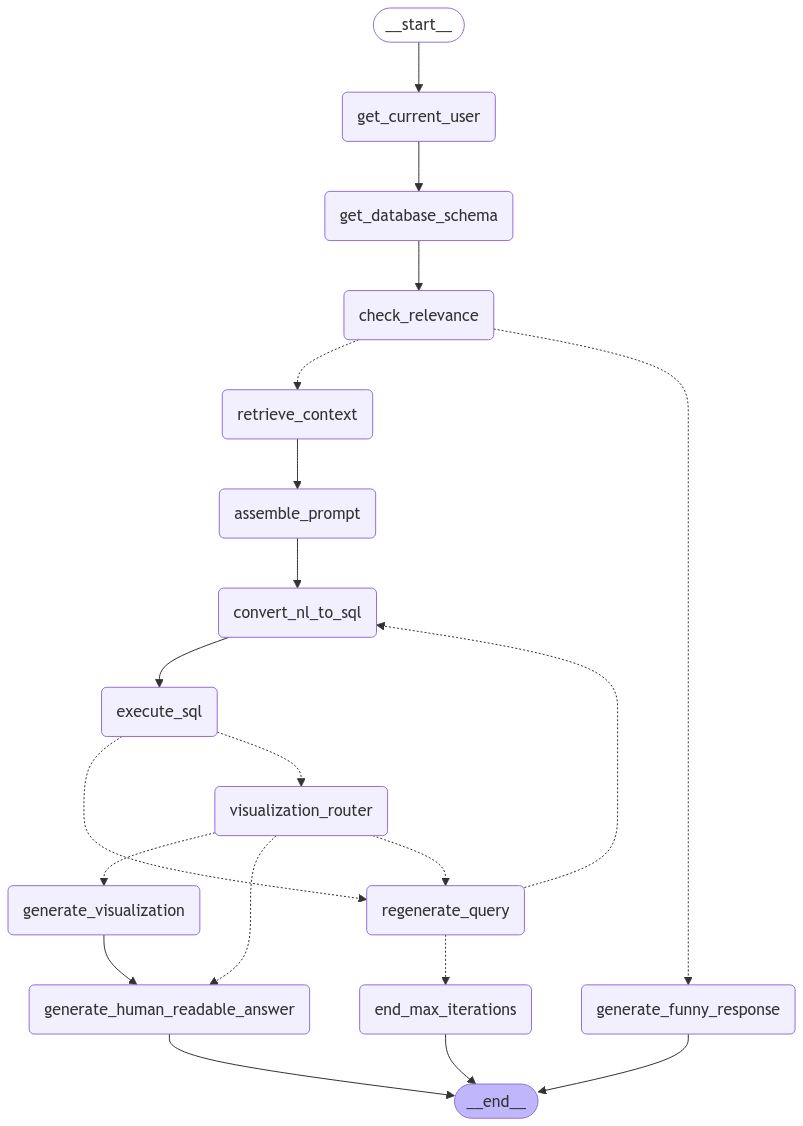

In [183]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [184]:
# save the graph
save_path = "workflow_graph.png"
graph = app.get_graph(xray=True).draw_mermaid_png()
with open(save_path, "wb") as f:
    f.write(graph)

In [120]:
fake_config = {"configurable": {"current_user_id": "3"},"recursion_limit": 50}

In [10]:
def get_orders_for_user(user_id: int):
    session = SessionLocal()
    try:
        orders = (
            session.query(Order)
            .join(Food, Order.food_id == Food.id)
            .filter(Order.user_id == user_id)
            .all()
        )
        if not orders:
            print(f"No orders found for user_id {user_id}.")
            return []

        order_list = []
        for order in orders:
            order_info = {
                "order_id": order.id,
                "food_name": order.food.name,
                "price": order.food.price
            }
            order_list.append(order_info)

        return order_list
    except Exception as e:
        print(f"Error retrieving orders for user_id {user_id}: {e}")
        return []
    finally:
        session.close()

orders = get_orders_for_user(5)
orders

[{'order_id': 8, 'food_name': 'Street_229709', 'price': 1000.07},
 {'order_id': 54, 'food_name': 'Spaghetti Carbonara', 'price': 41.81},
 {'order_id': 55, 'food_name': 'Spaghetti Carbonara', 'price': 41.81}]

In [11]:
user_question_2 = "Tell me about most expensive food all over the world."
result_2 = app.invoke({"question": user_question_2, "attempts": 0}, config=fake_config)
print("Result:", result_2["query_result"])

Retrieving the current user based on user ID.
Current user set to: William Walton
[DEBUG] Retrieving database schema...


/var/folders/l_/0pvlnhtj7pd0f1ysthdyb6fc0000gn/T/ipykernel_22790/675858157.py:117: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([SystemMessage(content=system_prompt)])


[DEBUG] Generated database description: The database is designed to manage a food-related business, encompassing various aspects such as inventory, sales, and customer interactions. Key tables include 'ingredients', 'vendors', and 'suppliers', which likely manage the procurement and sourcing of food items and raw materials. The 'food' and 'food_category' tables, along with the 'food_category_mapping', organize the food items offered, categorizing them for easier management and retrieval. 

Sales and customer transactions are handled through the 'orders' and 'payments' tables, which track customer purchases and payment details. The 'discounts' table is likely used to manage promotional offers, while the 'loyalty_program' table tracks customer loyalty initiatives, possibly offering rewards or incentives. Customer feedback and satisfaction are captured in the 'reviews' table, providing insights into customer experiences and preferences. Overall, the database integrates supply chain manage

Retrieving the current user based on user ID.
Current user set to: Kevin Aguirre
[DEBUG] Generated database description: This database is designed to manage a comprehensive system for a business that deals with food services, likely a restaurant or a chain of restaurants. The 'coupons' table manages promotional offers, which can be linked to the 'loyalty_program' table that tracks customer engagement and rewards. The 'vendors' table stores information about suppliers, which is crucial for maintaining the 'inventory' table that tracks stock levels of food items. The 'food_category' and 'food_category_mapping' tables organize food items into categories, which can be used in conjunction with the 'recipes' table to manage menu offerings.

The 'schedules' table likely handles the timing and availability of services or employee shifts, which ties into the 'employees' table that manages staff information. The 'user_activity' table records customer interactions, possibly including purchases or

/var/folders/l_/0pvlnhtj7pd0f1ysthdyb6fc0000gn/T/ipykernel_22790/3157612691.py:282: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


[DEBUG] Visualization Decision: {'visualize': True, 'chart_type': 'bar'}
[DEBUG] Starting advanced visualization generation
[DEBUG] Generating human-readable answer with LLM
[DEBUG] Generated Human-Readable Explanation: Hello!

Based on your request, we have successfully retrieved and visualized the data concerning the current coupons available in your system. Here's a summary of the information:

### Overview of the Query Results:

1. **Coupon Codes and Discounts:**
   - We have a list of five different coupon codes, each with a specific discount percentage.
   - The discounts range from approximately 9.9% to 21.92%.

2. **Expiry Dates:**
   - Each coupon also has a corresponding expiration date, ranging from February 18, 2025, to September 16, 2025.

### Insights from the Data:

- **Discount Range:**
  - The highest discount is offered by the coupon code **COUPONUqyN** at 21.92%, expiring on May 3, 2025.
  - The lowest discount is from **COUPONPiTu** at 9.9%, expiring on February 18,

<Figure size 1200x700 with 0 Axes>

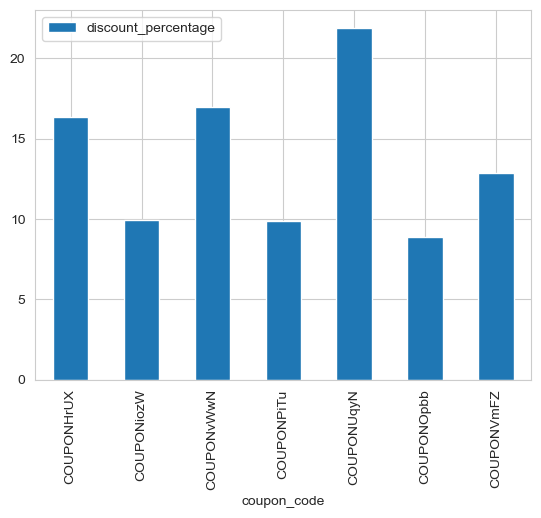

In [171]:
user_question_3 = '''Show me all coupon names, with their discount values and expiry dates, 
    use bar chart for visualization: for x axis use coupon code, 
    for y axis use discount values and top of the bar should show expiry date.'''

result_3 = app.invoke({"question": user_question_3, "attempts": 0}, config=fake_config)
print("Result:", result_3["query_result"])

In [153]:
user_question_1 = '''Show me top 5 most cheap food name from database and their prices'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: Kevin Aguirre
[DEBUG] Generated database description: This database is designed to manage a comprehensive food supply and sales system, encompassing various aspects from inventory management to customer engagement. The 'ingredients' and 'inventory' tables are crucial for tracking the availability and stock levels of food items, ensuring that the necessary components for recipes are always on hand. The 'food' and 'food_category' tables, along with the 'food_category_mapping', organize food items into categories, facilitating easy retrieval and management of food-related data. The 'vendors' and 'suppliers' tables are essential for managing relationships with external partners who provide the food and ingredients, while the 'recipes' table details the preparation methods and required ingredients for each dish.

Customer engagement and sales are supported by the 'coupons', 'discounts', and 'loyalty_program' tables, which he

<Figure size 1200x700 with 0 Axes>

In [43]:
print(type(graph))  # Should output <class 'networkx.classes.digraph.DiGraph'>


<class 'bytes'>


Retrieving the current user based on user ID.
Current user set to: Kevin Aguirre
[DEBUG] Generated database description: This database is designed to manage a comprehensive food-related service platform, incorporating various aspects such as user interactions, vendor management, and loyalty programs. The 'users' table stores essential user information, which is linked to the 'user_activity' table that tracks user interactions and activities on the platform. The 'vendors' table contains details about the food vendors, which are likely associated with the 'coupons' table to manage promotional offers. The 'food_category' and 'food_category_mapping' tables organize and map different food categories, which are essential for categorizing the 'recipes' stored in the database. 

The 'employees' table manages information about the staff involved in the platform's operations, while the 'payments' table records financial transactions, possibly linked to both users and vendors. The 'reviews' table

/var/folders/l_/0pvlnhtj7pd0f1ysthdyb6fc0000gn/T/ipykernel_22790/3157612691.py:282: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


[DEBUG] Visualization Decision: {'visualize': True, 'chart_type': 'bar'}
[DEBUG] Starting advanced visualization generation
[DEBUG] Generating human-readable answer with LLM
[DEBUG] Generated Human-Readable Explanation: Hello! Let's take a look at the top users with the highest points on the platform.

The query you executed fetched the top 5 users based on their points from the loyalty program. Here's a summary of the results:

1. **Bryan Fitzgerald** leads with an impressive 933 points.
2. **Courtney Smith** follows closely with 907 points.
3. **Mandy Perkins** appears twice, indicating she might have two different accounts or entries, with 901 and 822 points respectively.
4. **Terri Garrison** rounds out the list with 706 points.

This data gives us insights into the most engaged users on your platform, as these points likely reflect their activity, purchases, or interactions within the service. Such information is valuable for recognizing and rewarding loyal users, and possibly for

<Figure size 1200x700 with 0 Axes>

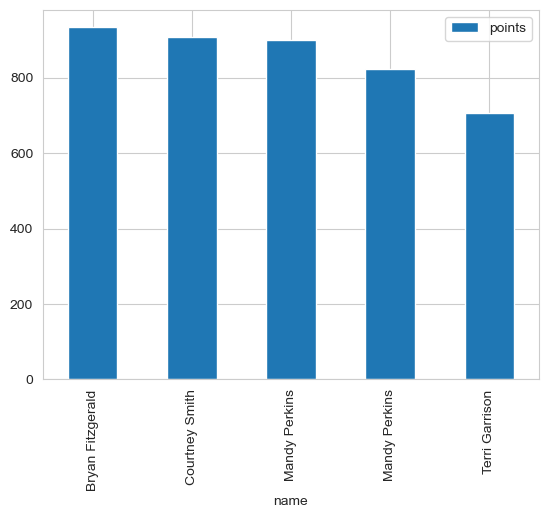

In [172]:
user_question_1 = '''Show me top 5 users who has highest points, and use a bar chart.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: Kevin Aguirre
[DEBUG] Generated database description: This database appears to be designed for a food service or restaurant management system, encompassing various aspects of operations, from inventory to customer interactions. The 'ingredients', 'vendors', and 'suppliers' tables likely manage the procurement and inventory of food items, with 'ingredients' detailing the items, 'vendors' listing the sources, and 'suppliers' providing additional procurement details. The 'food_category' and 'food' tables categorize and list the menu items, respectively, which are essential for organizing the offerings. The 'recipes' table, with its six columns, probably links ingredients to specific dishes, detailing preparation instructions and ingredient quantities.

The 'schedules' and 'employees' tables are crucial for workforce management, with 'schedules' likely detailing work shifts and 'employees' providing staff information. Custo

/var/folders/l_/0pvlnhtj7pd0f1ysthdyb6fc0000gn/T/ipykernel_22790/3157612691.py:282: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


[DEBUG] Visualization Decision: {'visualize': True, 'chart_type': 'bar'}
[DEBUG] Starting advanced visualization generation
[DEBUG] Generating human-readable answer with LLM
[DEBUG] Generated Human-Readable Explanation: Hello!

I've reviewed the results of your query, which looked into the average salaries for different positions within your organization. Here's a summary of what we found:

- **Entry-Level Positions:** The average salary for entry-level positions is approximately 22,278,268. This figure suggests that even at the entry level, the compensation is quite significant, which might reflect the value placed on new talent or the nature of the roles.

- **Intern Positions:** Interns have an average salary of about 3,450,945.2. This is notably lower than entry-level positions, which is typical as internships are often seen as learning opportunities with less responsibility compared to full-time roles.

- **Senior Positions:** The average salary for senior positions is around 106,

<Figure size 1200x700 with 0 Axes>

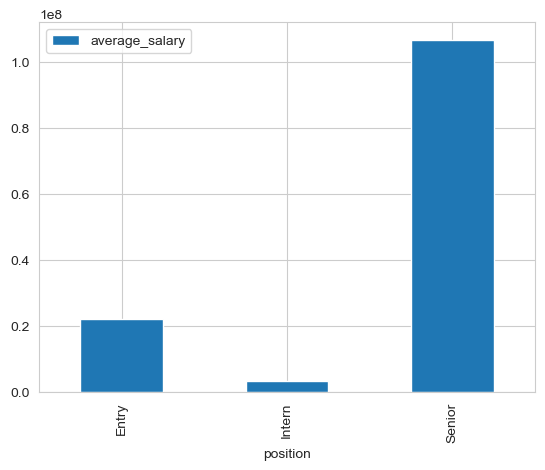

In [173]:
user_question_1 = '''Show me average Salary by position, use nice visualization.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


In [138]:
user_question_1 = '''Show percentage of each food category sold, use a pie chart.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


Retrieving the current user based on user ID.
Current user set to: Kevin Aguirre
[DEBUG] Generated database description: This database appears to be designed for a food-related business, possibly a restaurant or a food delivery service, with a focus on customer engagement and operational management. The key tables include 'users', which likely stores customer information, and 'employees', which manages staff details. The 'food' and 'food_category' tables, along with 'food_category_mapping', organize the menu items and their classifications. 'Vendors' and 'suppliers' tables are crucial for managing relationships with external partners who provide goods and services. 

The 'coupons' and 'loyalty_program' tables are designed to enhance customer retention and incentivize purchases through discounts and rewards. 'User_activity' and 'reviews' tables track customer interactions and feedback, providing insights into user behavior and satisfaction. The 'recipes' table may store detailed informa

<Figure size 1200x700 with 0 Axes>

Retrieving the current user based on user ID.
Current user set to: Kevin Aguirre
[DEBUG] Generated database description: The database is designed to manage a food-related business, encompassing various aspects such as inventory, sales, and customer engagement. The 'ingredients' and 'inventory' tables are crucial for tracking the stock and availability of food items, ensuring that the business can efficiently manage its supplies. The 'vendors' table likely stores information about suppliers, facilitating the procurement process. The 'recipes' table, with its six columns, suggests a detailed record of food preparation instructions, possibly linked to the 'ingredients' table to manage the components of each recipe.

Customer interactions and sales are managed through the 'users', 'user_activity', 'payments', and 'loyalty_program' tables. These tables collectively handle user information, track their activities, process payments, and manage customer loyalty initiatives, enhancing customer 

/var/folders/l_/0pvlnhtj7pd0f1ysthdyb6fc0000gn/T/ipykernel_22790/3157612691.py:282: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


[DEBUG] Visualization Decision: {'visualize': True, 'chart_type': 'pie'}
[DEBUG] Starting advanced visualization generation
[DEBUG] Generating human-readable answer with LLM
[DEBUG] Generated Human-Readable Explanation: Hello!

I see that you've retrieved some interesting data regarding the discount percentages of various food-related coupons. Let's break it down and understand what this information tells us.

### Overview of the Query Results

The data you've provided includes a list of coupon codes along with their respective discount percentages. Here are the details:

1. **COUPONHrUX** offers a discount of **16.34%**.
2. **COUPONiozW** provides a **9.92%** discount.
3. **COUPONvWwN** has a discount of **16.96%**.
4. **COUPONPiTu** offers a **9.9%** discount.
5. **COUPONUqyN** provides the highest discount at **21.92%**.

### Insights and Trends

- **Variety of Discounts**: The discount percentages vary from just under 10% to almost 22%, indicating a range of promotional strategies.

<Figure size 1200x700 with 0 Axes>

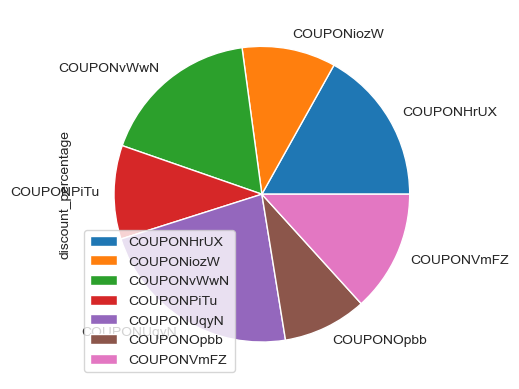

In [175]:
user_question_1 = ''' Analyze food's discount percentage, and show it in a pie chart, 
try to make it colorful and don't forget to add a title, also don't overlap it.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])


In [177]:
user_question_1 = ''' Show a scatter plot of price vs. discount percentage for food items, try your best to make it look good.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])

Retrieving the current user based on user ID.
Current user set to: Kevin Aguirre
[DEBUG] Generated database description: This database is designed to manage a comprehensive food service or retail operation, encompassing various aspects from inventory to customer interactions. The 'ingredients', 'inventory', and 'vendors' tables are likely interconnected, managing the supply chain by tracking available stock and supplier information. The 'recipes' table, with its six columns, probably details the composition of menu items, potentially linking to 'ingredients' for sourcing. Customer engagement is captured through the 'users', 'user_activity', 'reviews', and 'loyalty_program' tables, which collectively track user interactions, feedback, and reward participation. The 'coupons' and 'payments' tables facilitate transaction management, offering discounts and processing payments. Lastly, the 'food_category' and 'food_category_mapping' tables organize menu items into categories, aiding in menu 

Retrieving the current user based on user ID.
Current user set to: Kevin Aguirre
[DEBUG] Generated database description: This database is designed to manage a comprehensive food-related system, encompassing various aspects such as ingredients, recipes, vendors, and user interactions. The 'ingredients' and 'recipes' tables are central to the culinary aspect, with 'recipes' likely detailing the composition and preparation of dishes using entries from the 'ingredients' table. The 'food_category' and 'food_category_mapping' tables help organize and classify these recipes and ingredients into specific categories, facilitating easier navigation and management. 

The 'vendors' table stores information about suppliers, which could be linked to the 'ingredients' table to track sourcing details. User interactions and transactions are captured through the 'users', 'user_activity', 'payments', and 'loyalty_program' tables, which together manage user profiles, track their activities, process paymen

/var/folders/l_/0pvlnhtj7pd0f1ysthdyb6fc0000gn/T/ipykernel_22790/3157612691.py:282: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


[DEBUG] Visualization Decision: {'visualize': True, 'chart_type': 'bar'}
[DEBUG] Starting advanced visualization generation
[DEBUG] Generating human-readable answer with LLM
[DEBUG] Generated Human-Readable Explanation: Hello!

I've created a bar chart for you that displays the names of users with a 'Silver' membership tier and their corresponding points. Here's a summary of what the chart shows:

- **User Overview**: The chart includes five users: Adam Liu, Kelly Bright, Terri Garrison (appearing twice with different point totals), and Mandy Perkins.
- **Points Distribution**: Each bar represents the points accumulated by these users. Notably, Mandy Perkins has the highest points, standing at 901, which is highlighted in red for easy identification.
- **Key Insight**: Mandy Perkins is the leading Silver member in terms of points, which could indicate high engagement or frequent transactions. Terri Garrison appears twice, suggesting there might be a data entry error or multiple account

<Figure size 1200x700 with 0 Axes>

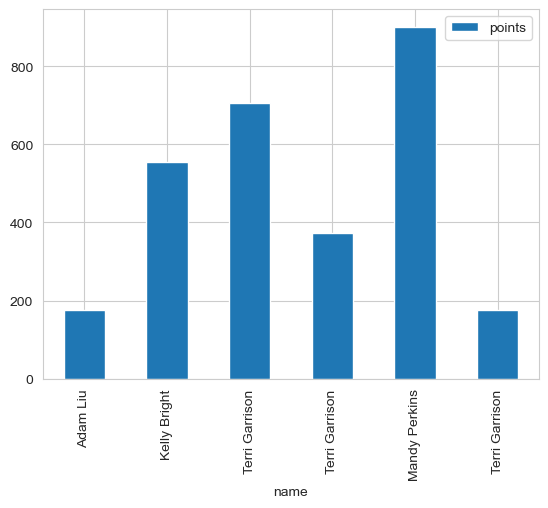

In [181]:
user_question_1 = ''' Show me every silver user names and their points, use a bar chart, highlight the highest point with red color.'''
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=fake_config)
print("Result:", result_1["query_result"])